# 最適ウェイト

##1 目的
不要波の到来方向にヌルを向けるウェイト$w_{\mbox{opt} }$を作成する

## 2 手順
$L$本の受信アンテナに所望信号$s$，干渉波$u$，熱雑音が加わって以下のように表現されたとする．
$$
\boldsymbol{x} = s \boldsymbol{x}_s + u \boldsymbol{x}_u + \boldsymbol{n}
$$
これによいウェイト$\boldsymbol{w}$をかけて$\boldsymbol{w}^H \boldsymbol{x}$を所望信号$s$に近づけたい．MMSE基準では以下であることがわかっている．

$$
\boldsymbol{w}_{ \mbox{opt} } =  R_{xx}^{-1} \boldsymbol{r}_{xs}
$$

ただし$R_{xx}, \boldsymbol{r}_{xs}$はそれぞれ以下で表現される相関行列および相関ベクトルである．

$$
R_{xx} = \mathbb{E}\big[\boldsymbol{x} \boldsymbol{x}^H\big] \\
= P_s \boldsymbol{x}_s \boldsymbol{x}_s^H + P_u \boldsymbol{x}_u \boldsymbol{x}_u^H + P_n I_L \\
\boldsymbol{r}_{xs} = P_s X_s
$$

具体的にアレー応答ベクトルの表現をおいておく：
$$
\boldsymbol{x}_s = \Bigg[ \exp\Big\{-j
\frac{2\pi}{\lambda} (i - 1) d \sin \theta_s
\Big\}\Bigg]_{i = 1, 2, \cdots, L} \\
\boldsymbol{x}_u = \Bigg[ \exp\Big\{-j
\frac{2\pi}{\lambda} (i - 1) d \sin \theta_u
\Big\}\Bigg]_{i = 1, 2, \cdots, L} 
$$


#3 具体的な実験
受信アンテナ#$i (= 1, 2, \cdots, L)$にある角度$\theta$から
$$
v(i; \theta) = \exp\Big[-j\pi (i - 1) \sin \theta \Big]
$$
という信号が到来したときに以下のシミュレーションパラメータを用いて$30^\circ$の到来信号を検出するウェイトを作成し，乗算することで，実際に到来方向が正しく推定できちるのか確認する．ただし，出力SNRは
$$
D_P (\theta) = \frac{1}{2} \bigg\| \boldsymbol{w}_{\mbox{opt}}^H \boldsymbol{V}(\theta) \bigg\|^2
とする．
$$

|  TH  |  TH  |
| ---- | ---- |
|  送信アンテナ数$T$  |  $2$  |
|  受信アンテナ数$R$  |  $2, 4$（可変）  |
| 所望波の角度$\theta_s$ | $30^\circ$ |
| 不要波の角度$\theta_u$ | $-60^\circ$ |
| 光速$c$ | $3.0 \times 10^8$ |
|信号周波数$f$ | $2.4\times 10^9$ |
| 各電力 | $P_s = 1.0, P_u = 1.0, P_n = 0.01$ |
| 推定到来範囲 $\theta$ | $-90^\circ \leq \theta \leq 90^\circ$  |

簡単な計算より波長は$\lambda = 0.125$,アンテナ間距離は$d = 6.25 \times 10^{-2}$とわかる

In [421]:
!python --version

Python 3.7.13


In [422]:
import numpy as np
import math
import matplotlib.pyplot as plt

In [423]:
#アダプティブアレーアンテナ
class AdaptiveArrayAntenna:

  #constructor
  def __init__(self,
               T,
               R,
               thetaSignal,
               thetaInterference,
               waveLength,
               d,
               powerOfSignal,
               powerOfInterference,
               powerOfNoise
               ):
    self.T = T
    self.R = int(R)
    self.thetaSignal = thetaSignal
    self.thetaInterference = thetaInterference
    self.waveLength = waveLength
    self.d = d
    self.powerOfSignal = powerOfSignal
    self.powerOfInterference = powerOfInterference
    self.powerOfNoise = powerOfNoise

    self.Xs = self.calcArrayResponseVector( self.thetaSignal )

    self.Xu = self.calcArrayResponseVector( self.thetaInterference )

    self.Rxx = self.calcRxx()

    self.rxs = self.calcrxs()

    self.weightOpt = self.calcWeightOpt()
  
  #アレー応答ベクトル計算
  def calcArrayResponseVector(self, theta) :
    arrayResponseVector = np.array([
        [
            np.exp(
              - 1j * 2.0 * np.pi / self.waveLength * r * self.d * math.sin(theta)
            )   
        ] for r in range(self.R)
    ])
    return arrayResponseVector
    
  
  #相関行列計算
  def calcRxx(self):
    return (
        self.powerOfSignal * self.Xs @ np.conjugate( self.Xs ).T +
        self.powerOfInterference * self.Xu @ np.conjugate( self.Xu ).T +
        self.powerOfNoise * np.identity(self.R)
    )
  
  #相関ベクトル計算
  def calcrxs(self):
    return self.powerOfSignal * self.Xs

  #最適ウェイト計算(MMSE基準)
  def calcWeightOpt(self):
    return np.linalg.inv( self.Rxx ) @ self.rxs
  
  #θから信号が来たと予測し，そのときのSNRを計算
  def calcSNR(self, theta):
    SNR = abs( 
        np.conjugate( self.weightOpt ).T @  
        np.exp(
            - 1j * 2.0 * np.pi / self.waveLength * np.arange( self.R ) * self.d * np.sin(theta)
          )
        ) ** 2
    SNR /= 2

    #[dB]に直す
    return 10.0 * np.log10(SNR)

## 受信アンテナ数が$R = 2$のとき

In [424]:
adaptiveArrayAntennaR2 = AdaptiveArrayAntenna(
    T = 1,
    R = 2,
    thetaSignal = 30 * math.pi / 180,
    thetaInterference = -60 * math.pi / 180,
    waveLength = 0.125,
    d = 0.0625,
    powerOfSignal = 1.0,
    powerOfInterference = 1.0,
    powerOfNoise = 0.01
)

In [425]:
theta = np.arange(-90, 91)
SNR_R2 = np.array([
    adaptiveArrayAntennaR2.calcSNR( theta_ * np.pi / 180 )
    for theta_ in theta
])

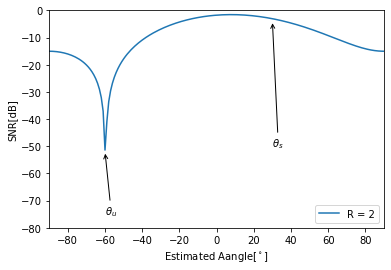

In [426]:
plt.plot(theta, SNR_R2, label = "R = 2")

plt.xlim(-90, 90)
plt.ylim(-80, 0)
plt.xlabel("Estimated Aangle$[^\circ]$")
plt.ylabel("SNR[dB]")

plt.annotate(r'$\theta_s$', (30, -4), (30, -50),arrowprops=dict(arrowstyle="->"))
plt.annotate(r'$\theta_u$', (-60, -52), (-60, -75),arrowprops=dict(arrowstyle="->"))

plt.legend(loc = "lower right")

plt.savefig("movingIntergerenceWaveR2.png")

plt.show()

## 受信アンテナ数が$R = 4$のとき

In [427]:
adaptiveArrayAntennaR4 = AdaptiveArrayAntenna(
    T = 1,
    R = 4,
    thetaSignal = 30 * math.pi / 180,
    thetaInterference = -60 * math.pi / 180,
    waveLength = 0.125,
    d = 0.0625,
    powerOfSignal = 1.0,
    powerOfInterference = 1.0,
    powerOfNoise = 0.01
)

In [428]:
theta = np.arange(-90, 91)
SNR_R4 = np.array([
    adaptiveArrayAntennaR4.calcSNR( theta_ * np.pi / 180 )
    for theta_ in theta
])

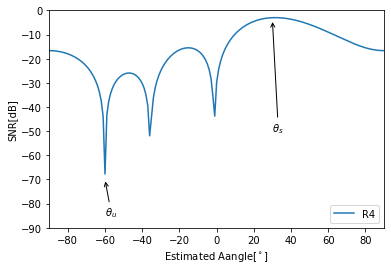

In [429]:
plt.plot(theta, SNR_R4, label = "R4")

plt.xlim(-90, 90)
plt.ylim(-90, 0)
plt.xlabel("Estimated Aangle$[^\circ]$")
plt.ylabel("SNR[dB]")

plt.annotate(r'$\theta_s$', (30, -4), (30, -50),arrowprops=dict(arrowstyle="->"))
plt.annotate(r'$\theta_u$', (-60, -70), (-60, -85),arrowprops=dict(arrowstyle="->"))


plt.legend(loc = "lower right")

plt.savefig("movingIntergerenceWaveR4.png")

plt.show()

## まとめ

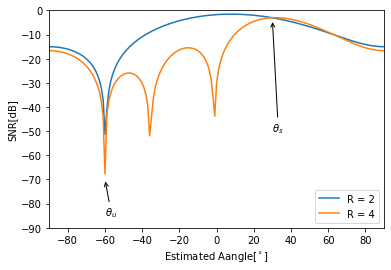

In [430]:
plt.plot(theta, SNR_R2, label = "R = 2")
plt.plot(theta, SNR_R4, label = "R = 4")

plt.xlim(-90, 90)
plt.ylim(-90, 0)
plt.xlabel("Estimated Aangle$[^\circ]$")
plt.ylabel("SNR[dB]")

plt.annotate(r'$\theta_s$', (30, -4), (30, -50),arrowprops=dict(arrowstyle="->"))
plt.annotate(r'$\theta_u$', (-60, -70), (-60, -85),arrowprops=dict(arrowstyle="->"))


plt.legend(loc = "lower right")

plt.savefig("movingIntergerenceWave.png")

plt.show()